In [1]:

from __future__ import print_function

import sys

# sys.path.extend(['/home/jogi/git/repository/dcnn_acdc'])
sys.path.extend(['/home/jorg/repository/dcnn_acdc'])

import matplotlib
import matplotlib.pyplot as plt

from matplotlib import cm


from datetime import datetime
from pytz import timezone
import itertools
import copy

import SimpleITK as sitk
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init

import numpy as np
import dill
import os
import glob
from collections import OrderedDict

from in_out.load_data import ACDC2017DataSet
from config.config import config
from utils.experiment import Experiment, ExperimentHandler
from utils.batch_handlers import TwoDimBatchHandler

from models.dilated_cnn import BaseDilated2DCNN

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:

exper = ExperimentHandler.load_experiment("/home/jorg/repository/dcnn_acdc/logs/20180213_16_03_27_dcnnv1_100E_lr2e03")

exper_hdl = ExperimentHandler(exper, use_logfile=False)

Load from /home/jorg/repository/dcnn_acdc/logs/20180213_16_03_27_dcnnv1_100E_lr2e03/stats/exper_stats.dll


In [4]:
dataset = ACDC2017DataSet(exper_hdl.exper.config, search_mask=config.dflt_image_name + ".mhd",
                          fold_ids=[0], preprocess=False, debug=True)

INFO - Using folds [0] - loaded 6 files: 96 slices in train set, 40 slices in validation set


In [6]:
new_batch = TwoDimBatchHandler(exper_hdl.exper, batch_size=1)
new_batch.generate_batch_2d(dataset.train_images, dataset.train_labels)

In [57]:
new_batch.save_batch_img_to_files()
# lbl = new_batch.b_labels[0].data.cpu().numpy()
# print(np.unique(lbl))

Batch-size 1 / classes 8
Successfully saved image to /home/jorg/repository/dcnn_acdc/data/Folds/b01_img_ph0.nii
(0, 1, array([ 0.], dtype=float32), (151, 151))
Successfully saved image to /home/jorg/repository/dcnn_acdc/data/Folds/b01_lbl_ph0_cls1.nii
(0, 2, array([ 0.,  1.], dtype=float32), (151, 151))
Successfully saved image to /home/jorg/repository/dcnn_acdc/data/Folds/b01_lbl_ph0_cls2.nii
(0, 3, array([ 0.,  1.], dtype=float32), (151, 151))
Successfully saved image to /home/jorg/repository/dcnn_acdc/data/Folds/b01_lbl_ph0_cls3.nii
Successfully saved image to /home/jorg/repository/dcnn_acdc/data/Folds/b01_img_ph1.nii
(0, 1, array([ 0.], dtype=float32), (151, 151))
Successfully saved image to /home/jorg/repository/dcnn_acdc/data/Folds/b01_lbl_ph1_cls1.nii
(0, 2, array([ 0.,  1.], dtype=float32), (151, 151))
Successfully saved image to /home/jorg/repository/dcnn_acdc/data/Folds/b01_lbl_ph1_cls2.nii
(0, 3, array([ 0.,  1.], dtype=float32), (151, 151))
Successfully saved image to /home

(55, 0)
(2, 151, 151)


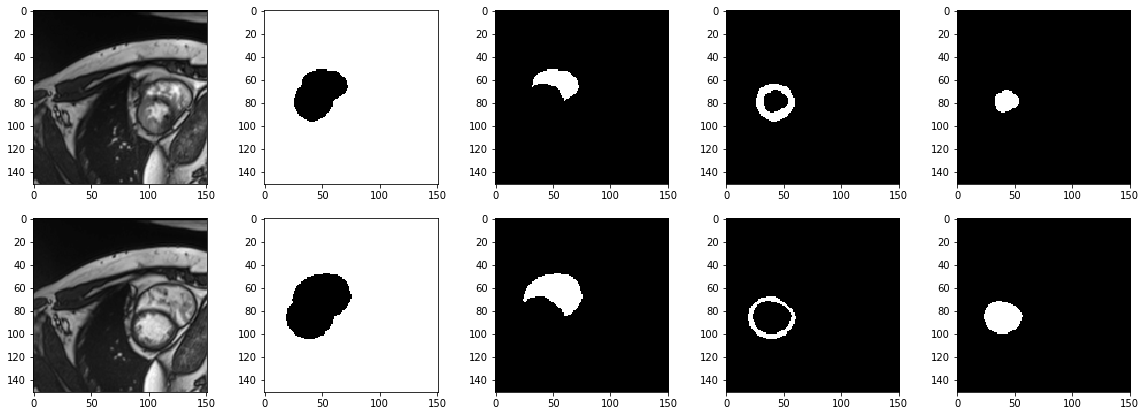

In [13]:
new_batch.visualize_batch(width=20, height=30)

(151, 151)


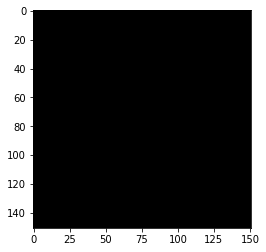

In [59]:
from in_out.read_save_images import load_mhd_to_numpy

img_filename = "/home/jorg/repository/dcnn_acdc/data/Folds/b01_lbl_ph0_cls1.nii"
img = load_mhd_to_numpy(img_filename)
print(img[0].shape)
plt.imshow(img[0], cmap=cm.gray)
plt.show()

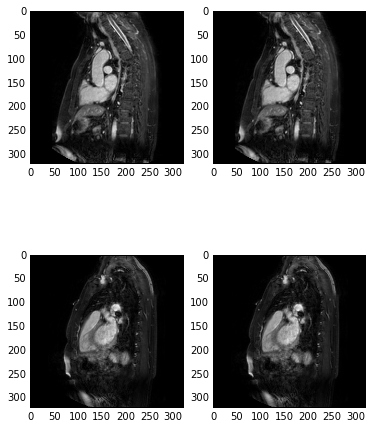

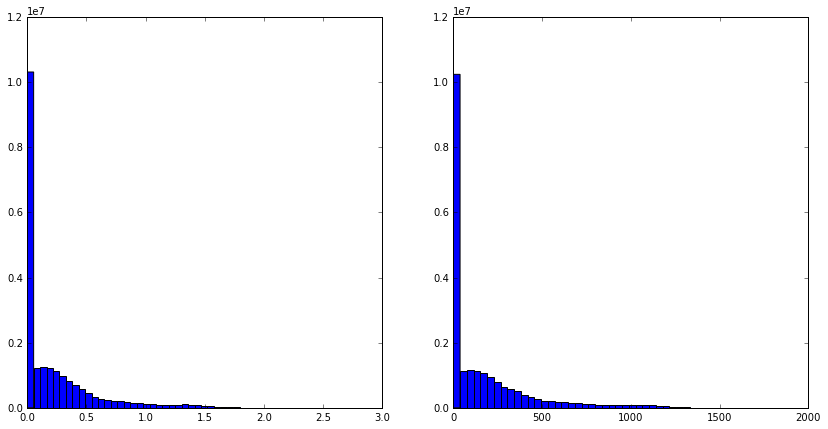

In [3]:

all_data_raw = np.empty(0)
all_data_norm = np.empty(0)

l_dataset = data_set.__len__()
series_idx = 50
fig = plt.figure(figsize=(6, 8))
counter = 0
data_set.normalize_values()

for idx in np.arange(l_dataset):
    img = data_set.images_raw[idx]
    img_norm = data_set.images[idx]
    all_data_raw = np.append(all_data_raw, np.ravel(img))
    all_data_norm = np.append(all_data_norm, np.ravel(img_norm))
    counter += 1
    ax = plt.subplot(l_dataset, 2, counter)
    plt.imshow(img[series_idx], cmap=cm.gray)
    counter += 1
    ax = plt.subplot(l_dataset, 2, counter)
    plt.imshow(img_norm[series_idx], cmap=cm.gray)

plt.show()
plt.close()

data_set.show_histogram(raw=True)

(320, 320)
(320, 320)
0.0 1516.0


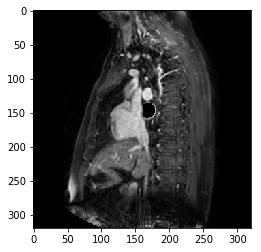

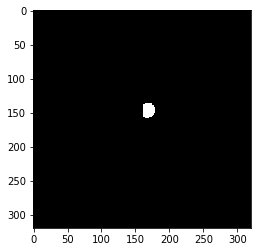

In [71]:
target = 67
for idx, img_details in enumerate(images):
    img = img_details[0][target] # + gt_img_segs[idx][0]
    if idx == 0:
        print(img.shape)
        mask = gt_img_segs[idx][0][target] == 1
        print(mask.shape)
        print(np.min(img), np.max(img))
        img[mask] = 0

        plt.imshow(img[:, :], cmap=cm.gray)
        plt.show()
        plt.imshow(mask, cmap=cm.gray)